In [314]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [315]:
import xarray as xr
import numpy as np
import pandas as pd

import ecephys_analyses as ea 
from ecephys.plot import plot_hypnogram_overlay

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [316]:
from scipy import stats

In [317]:
xr.set_options(keep_attrs=True)

In [362]:
subject = 'Segundo'
experiment = 'novel_objects_deprivation'
condition = 'extended-wake'

In [465]:
hyp = ea.load_hypnogram(subject, experiment, condition)
#hyp = hyp.keep_states(['N1', 'N2']).keep_first('02:00:00')

pwr = ea.load_power(subject, experiment, condition, "spg.nc").swap_dims({'time': 'datetime'})
#pwr = pwr.sel(datetime=hyp.covers_time(pwr.datetime))

spws = ea.load_spws(subject, experiment, condition, abs_sink=True)
#spws = spws[hyp.covers_time(spws.start_time)]

In [466]:
def add_epoch(spws, epochs):
    spws = spws.copy()
    def get_epoch(spw):
        idx = epochs.searchsorted(spw.start_time, 'right') - 1
        return epochs.iloc[idx]
    
    spws['epoch'] = spws.apply(get_epoch, axis=1)
    
    return spws

def get_spw_timeseries(spws, epochs, agg_args):
    spws = add_epoch(spws, epochs)
    ts = spws.groupby('epoch').agg(agg_args)
    count_ts = spws.groupby('epoch').size().rename('count')
    return ts.join(count_ts)

In [467]:
pwr = pwr.resample(datetime='0.1S').mean()

In [468]:
spwt = get_spw_timeseries(spws, pwr.datetime.to_series(), 'mean')
spwt = xr.Dataset(spwt).rename({'epoch': 'datetime'})

In [469]:
count_psd_corr = xr.corr(spwt['count'], pwr['sr_wm_ref'], dim='datetime')
amplitude_psd_corr = xr.corr(spwt['sink_amplitude'], pwr['sr_wm_ref'], dim='datetime')
integral_psd_corr = xr.corr(spwt['sink_integral'], pwr['sr_wm_ref'], dim='datetime')
duration_psd_corr = xr.corr(spwt['duration'], pwr['sr_wm_ref'], dim='datetime')
corr = xr.Dataset({'count': count_psd_corr, 'amplitude': amplitude_psd_corr, 'integral': integral_psd_corr, 'duration': duration_psd_corr})

In [476]:
smoothing=1
title = ''

[Text(0, 0.5, 'correlation'), Text(0.5, 1.0, '')]

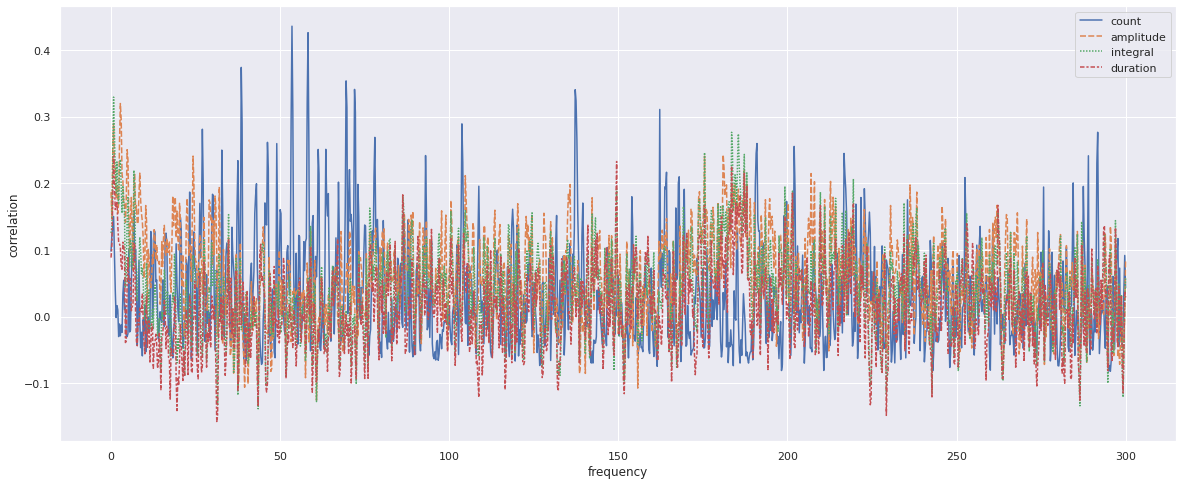

In [477]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(data=corr.rolling(frequency=smoothing, center=True).mean().to_dataframe(), ax=ax)
ax.set(ylabel='correlation', title=title)

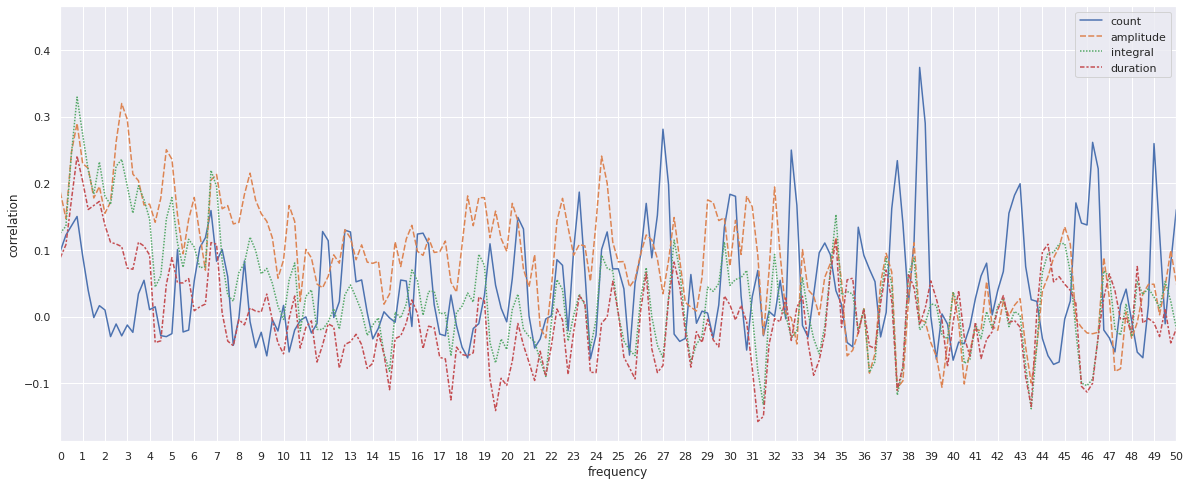

In [478]:
fig, ax = plt.subplots(figsize=(20, 8))
max_freq = 50
g = sns.lineplot(data=corr.rolling(frequency=smoothing, center=True).mean().to_dataframe(), ax=ax)
g = ax.set(ylabel='correlation', title=title, xlim=(0, max_freq), xticks=np.arange(0, max_freq + 1))